# TABLES DES MATIERES


# 1) LIBRAIRIES                 Cells to

# 2) INTRODUCTION          Cells to

# 3) Consolidation des données par Ordres                    Cells  to 

# 3) Consolidation des données par Clients     Cells  to 

# 4) Problématique: Rétention

# 1) LIBRAIRIES

In [1]:
import pandas as pd
import unicodedata
import calendar
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotnine import *
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
%matplotlib inline

# 2) INTRODUCTION 

### Importer des tables

In [2]:
orders = pd.read_csv('olist_orders_dataset.csv', delimiter=",")
payment = pd.read_csv('olist_order_payments_dataset.csv', delimiter=",")
customers=  pd.read_csv('olist_customers_dataset.csv', delimiter=",")
sellers=  pd.read_csv('olist_sellers_dataset.csv', delimiter=",")
products=  pd.read_csv('olist_products_dataset.csv', delimiter=",")
reviews=  pd.read_csv('olist_order_reviews_dataset.csv', delimiter=",")
items=  pd.read_csv('olist_order_items_dataset.csv', delimiter=",")
geolocation=  pd.read_csv('olist_geolocation_dataset.csv', delimiter=",")
product_category_name_translation = pd.read_csv('product_category_name_translation.csv')

### La table "base" est composée de la jointure entre les tables ORDERS,CUSTOMERS ET PAYMENT. 

In [3]:
base = pd.merge(orders, customers, on='customer_id', how='left')
base = pd.merge(base, payment, on='order_id', how='left')

## Formating and Sanity

CONVERTISSEUR EN DATETIME

In [4]:
base['order_approved_at'] = pd.to_datetime(base['order_approved_at'], errors='coerce')
base['order_delivered_carrier_date'] = pd.to_datetime(base['order_delivered_carrier_date'], errors='coerce')
base['order_delivered_customer_date'] = pd.to_datetime(base['order_delivered_customer_date'], errors='coerce')
base['order_estimated_delivery_date'] = pd.to_datetime(base['order_estimated_delivery_date'], errors='coerce')
base['order_purchase_timestamp'] = pd.to_datetime(base['order_purchase_timestamp'], errors='coerce')

Convertisseur en Categorisation

In [5]:
cat_name1 = base['order_status'].unique().tolist()
cat_name2= base['customer_city'].unique().tolist()
cat_name3= base['customer_state'].unique().tolist()
base['order_status'] = pd.Categorical(base['order_status'], categories=cat_name1, ordered=False)
base['customer_city'] = pd.Categorical(base['customer_city'], categories=cat_name2, ordered=False)
base['customer_state'] = pd.Categorical(base['customer_state'], categories=cat_name3, ordered=False)

Ici, pour catégoriser la variable "payment_type", nous devons d'abord remplacer les valeurs Nan par 'not defined'. 

In [6]:
base['payment_type'] = base['payment_type'].replace(np.nan, 'not_defined')
cat_name4=base['payment_type'].unique().tolist()
base['payment_type'] = pd.Categorical(base['payment_type'], categories=cat_name4, ordered=False)

In [7]:
base.dtypes

order_id                                 object
customer_id                              object
order_status                           category
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                          category
customer_state                         category
payment_sequential                      float64
payment_type                           category
payment_installments                    float64
payment_value                           float64
dtype: object

In [8]:
def supprime_accent(ligne):
        """ supprime les accents du texte source """
        accent = ['é', 'è', 'ê', 'à', 'ù', 'û', 'ç', 'ô', 'î', 'ï', 'â']
        sans_accent = ['e', 'e', 'e', 'a', 'u', 'u', 'c', 'o', 'i', 'i', 'a']
        i = 0
        while i < len(accent):
            base['ligne'] = ligne.replace(accent[i], sans_accent[i])
            i += 1
        return ligne
base['customer_city'].apply(supprime_accent) 
base['customer_state'].apply(supprime_accent)

0         SP
1         SP
2         SP
3         BA
4         GO
          ..
103882    SP
103883    SP
103884    BA
103885    RJ
103886    PR
Name: customer_state, Length: 103887, dtype: category
Categories (27, object): ['SP', 'BA', 'GO', 'RN', ..., 'PI', 'AL', 'AC', 'AM']

# 3) Consolidation des données par ordre

### Tout d'abord, nous allons rajouter les variables "month", "year","day"," hour", et "month_year". 

In [9]:
base['month'] = base['order_purchase_timestamp'].dt.strftime('%m')
base['year'] =  base['order_purchase_timestamp'].dt.strftime('%Y')
base['day'] =  base['order_purchase_timestamp'].dt.strftime('%d')
base['hour'] = base['order_purchase_timestamp'].dt.strftime('%H')
base['year_month'] = base['order_purchase_timestamp'].dt.strftime('%Y-%m')

### Combien il y'a d'ordres par mois ?

<AxesSubplot:xlabel='month'>

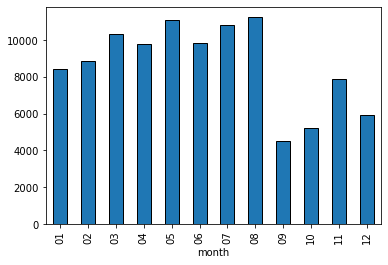

In [10]:
orders_per_months = base.groupby(base['month'])['order_id'].count()
orders_per_months.plot.bar()

Voici ci-dessus le nombre d'ordres par mois. C'est durant le mois d'aout qu'il y-en a le plus et c'est durant le mois suivant (septembre) qu'il y-en a le moins. 

### Combien de chiffre par mois ?

<AxesSubplot:xlabel='year_month'>

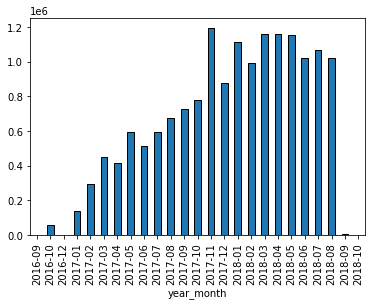

In [11]:
max_payment=base['payment_value'].max()
moyenne_payments=base['payment_value'].mean()
CA_per_months = base.groupby(base['year_month'])['payment_value'].sum()
CA_per_months.plot.bar()

C'est en novembre 2017 que l'on peut retrouver le chiffre d'affaire le plus élevé. 

In [12]:
print('CA moyen par mois:', CA_per_months.mean())
print('CA le pls élevé sur un mois:',CA_per_months.max())
print('Paiement record:', max_payment)
print('Paiement moyen:', moyenne_payments)

CA moyen par mois: 640354.8848
CA le pls élevé sur un mois: 1194882.7999999977
Paiement record: 13664.08
Paiement moyen: 154.10038041698772


### % d'ordres par heure

<AxesSubplot:>

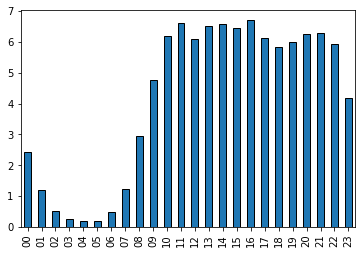

In [13]:
orders_per_hours = base['hour'].value_counts(normalize=True).sort_index()*100
orders_per_hours.plot.bar()

### % d'ordres par jour

<AxesSubplot:>

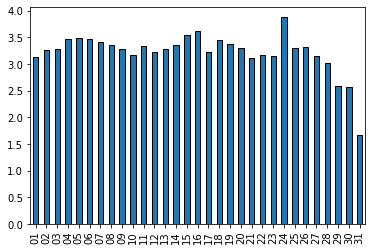

In [14]:
orders_per_day = base['day'].value_counts(normalize=True).sort_index()*100
orders_per_day.plot.bar()

### % de CA par jour ?

<AxesSubplot:xlabel='day'>

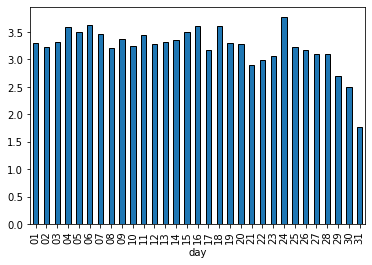

In [15]:
CA_per_days = pd.pivot_table(base, values=['payment_value'], index=['day'], aggfunc=np.sum)
CA_per_days['Pourcentage']= CA_per_days['payment_value'] / 16008872.12 *100
Somme_CA=CA_per_days.sum()
# Somme_CA = 16008872.12
CA_per_days['Pourcentage'].plot(kind='bar')

### % de CA par heure ?

<AxesSubplot:xlabel='hour'>

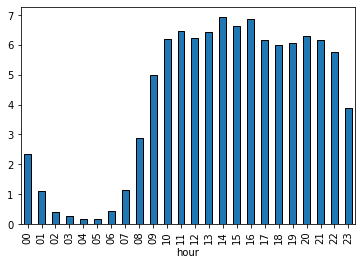

In [16]:
CA_per_days = pd.pivot_table(base, values=['payment_value'], index=['hour'], aggfunc=np.sum)
CA_per_days['Pourcentage']= CA_per_days['payment_value'] / 16008872.12 *100
Somme_CA=CA_per_days.sum()
# Somme_CA = 16008872.12
CA_per_days['Pourcentage'].plot(kind='bar')

### Répartition des states par ordres

<AxesSubplot:ylabel='customer_state'>

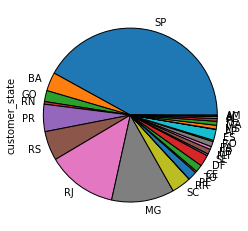

In [17]:
Ordres_par_states = pd.value_counts(base['customer_state']).sort_index() 
Ordres_par_states.plot.pie()

### Répartition des states par CA

<AxesSubplot:ylabel='payment_value'>

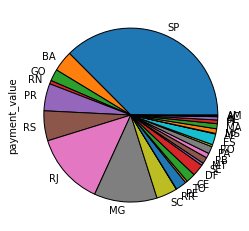

In [18]:
CA_par_states = base.groupby(['customer_state']).payment_value.sum()
CA_par_states.plot.pie()

### % d'ordres par moyen paiement par state

In [19]:
ordres_moyen_state = pd.crosstab(base['customer_state'], base['payment_type'], values=base['order_id'],
            aggfunc=pd.Series.count, normalize=True)

<AxesSubplot:xlabel='customer_state'>

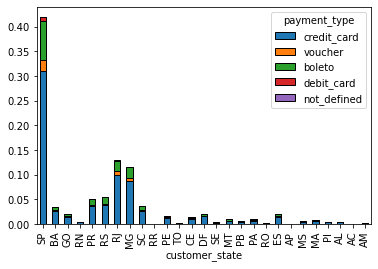

In [20]:
ordres_moyen_state.plot.bar(stacked=True)

### % de CA par moyen paiement par state

<AxesSubplot:xlabel='customer_state'>

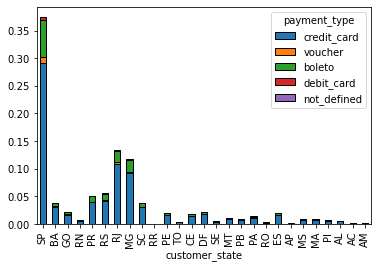

In [21]:
CA_moyen_state = pd.crosstab(base['customer_state'], base['payment_type'], values=base['payment_value'],
            aggfunc=pd.Series.sum, normalize=True)
CA_moyen_state.plot.bar(stacked=True)

### % d'ordres par moyen paiement par mois

<AxesSubplot:xlabel='year_month'>

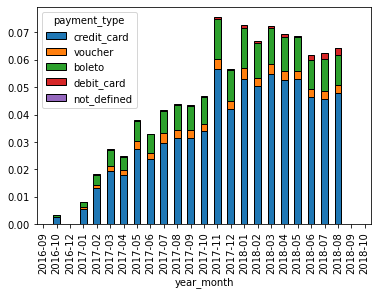

In [22]:
ordres_moyen_mois = pd.crosstab(base['year_month'], base['payment_type'], values=base['order_id'],
            aggfunc=pd.Series.count, normalize=True)
ordres_moyen_mois.plot.bar(stacked=True)

### % de CA par moyen paiement par mois

<AxesSubplot:xlabel='year_month'>

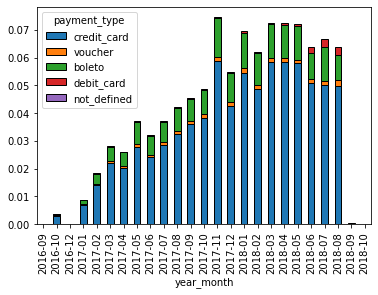

In [23]:
CA_par_mois_payment = pd.crosstab(base['year_month'], base['payment_type'], values=base['payment_value'],
            aggfunc=pd.Series.sum, normalize=True)
CA_par_mois_payment.plot.bar(stacked=True)

# 3) Consolidation des données par clients

### Nombre de commandes par client: 

In [24]:
Nb_commandes_par_clients = base.groupby(base['customer_id'])['order_id'].count()
Paiements_par_clients = base.groupby(['customer_id'])['payment_value'].sum()
print('Les clients passent en général une seule commande.    :', Nb_commandes_par_clients.mean())
print('Le record de commandes d un seul client.              :', Nb_commandes_par_clients.max())
print('La dépense moyenne d un client                        :', Paiements_par_clients.mean())
print('La dépense record pour un seul client.                :', Paiements_par_clients.max())

Les clients passent en général une seule commande.    : 1.0447099285003167
Le record de commandes d un seul client.              : 29
La dépense moyenne d un client                        : 160.98864774086096
La dépense record pour un seul client.                : 13664.08


In [44]:
len(Nb_commandes_par_clients)

99441

<AxesSubplot:>

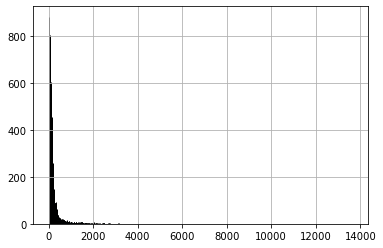

In [26]:
Paiements_par_clients.hist(bins = 14000, grid=True)

# 4) Problématique: Rétention 

Tout d'abord, nous allons combiner les payments pour un même client:

In [27]:
paiement_combiné=payment[['order_id','payment_value']].groupby('order_id').sum().reset_index()

On récupère notre table de départ avec seulement les colonnes qui nous intérressent. 

In [28]:
customer_order=pd.merge(customers,orders[['order_id','customer_id','order_purchase_timestamp']],on='customer_id')

In [29]:
new_base=pd.merge(customer_order,payment,on='order_id')
## on enlève ces colonnes 
new_base.drop(['customer_zip_code_prefix','customer_city','customer_state'],axis=1,inplace=True)


In [30]:
new_base['order_purchase_timestamp']=pd.to_datetime(new_base['order_purchase_timestamp']).dt.date


Ci dessous la dernière transaction pour chaque clients

In [31]:
dernière_transaction=pd.DataFrame(new_base.groupby('customer_unique_id')['order_purchase_timestamp'].max())

#### Voici l'intervalle de temps (en jours) entre la dernière transaction du client et la dernière transaction observée

In [32]:
dernière_transaction['intervalle']=dernière_transaction['order_purchase_timestamp'].max()-dernière_transaction['order_purchase_timestamp']
dernière_transaction['intervalle']=dernière_transaction['intervalle'].dt.days

Le nombre de transactions réalisées pour chaque client unique.

In [39]:
fréquence=pd.DataFrame(new_base.groupby('customer_unique_id')['customer_id'].count())
fréquence.describe()

,customer_id
count,96095.000000
mean,1.081076
std,0.462548
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,33.000000


Le montant des transactions réalisées pour chaque client unique.

In [34]:
montant = pd.DataFrame(new_base[['customer_unique_id','payment_value']].groupby('customer_unique_id')['payment_value'].sum())

In [36]:
dernière_transac_fréquence_montant=  pd.merge(dernière_transaction,fréquence,on='customer_unique_id')
dernière_transac_fréquence_montant=  pd.merge(dernière_transac_fréquence_montant ,montant,on='customer_unique_id')
dernière_transac_fréquence_montant.drop(['order_purchase_timestamp'],axis=1,inplace=True)
dernière_transac_fréquence_montant.reset_index(inplace=True)
dernière_transac_fréquence_montant.columns=['Client_unique','Intervalle','Fréquence','Montant']
dernière_transac_fréquence_montant

,Client_unique,Intervalle,Fréquence,Montant
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
2,0000f46a3911fa3c0805444483337064,586,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89
...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42
96091,fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58
96092,ffff371b4d645b6ecea244b27531430a,617,1,112.46
96093,ffff5962728ec6157033ef9805bacc48,168,1,133.69


In [37]:
dernière_transac_fréquence_montant.describe()

,Intervalle,Fréquence,Montant
count,96095.000000,96095.000000,96095.000000
mean,288.103866,1.081076,166.594226
std,153.411050,0.462548,231.428912
min,0.000000,1.000000,0.000000
25%,164.000000,1.000000,63.120000
50%,269.000000,1.000000,108.000000
75%,397.000000,1.000000,183.530000
max,773.000000,33.000000,13664.080000


### Seulement 3% des clients font plus d'un achat

In [38]:
(dernière_transac_fréquence_montant[dernière_transac_fréquence_montant['Fréquence']>1].shape[0]/96095)*100

5.961808626879651

In [45]:
(Nb_commandes_par_clients[Nb_commandes_par_clients>1].shape[0]/99441)*100

2.9776450357498416